<span style="font-size: 20px;">Item Demand Forcasting</span>



<span style="font-size: 20px;">Packages</span>



In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns
import lightgbm as lgb

warnings.filterwarnings("ignore")

# Set seeds to make the experiment more reproducible.
from numpy.random import seed
seed(1)


<span style="font-size: 20px;">Data</span>


In [2]:
data = pd.read_csv("demand_dataset.csv")
data['region'] = data['region'].str.split('_').str[1].astype(int)
data['city'] = data['city'].str.split('_').str[1].astype(int)
data['item_id'] = data['item_id'].str.split('_').str[1].astype(int)
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [3]:
data.head()


,timestamp,region,city,item_id,demand
0,2018-01-02,1,2,1,148
1,2018-01-03,1,2,1,124
2,2018-01-04,1,2,1,243
3,2018-01-05,1,2,1,199
4,2018-01-06,1,2,1,100


In [4]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13464 entries, 0 to 13463
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  13464 non-null  datetime64[ns]
 1   region     13464 non-null  int32         
 2   city       13464 non-null  int32         
 3   item_id    13464 non-null  int32         
 4   demand     13464 non-null  int64         
dtypes: datetime64[ns](1), int32(3), int64(1)
memory usage: 368.3 KB


In [5]:
print('Min date from train set: %s' % data['timestamp'].min().date())
print('Max date from train set: %s' % data['timestamp'].max().date())

Min date from train set: 2018-01-02
Max date from train set: 2024-05-05


<span style="font-size: 20px;">
Handling Null Values:

</span>



As there are no null values so we do not need to do anything

In [6]:
null_values=data.isnull().sum()
null_values=pd.DataFrame(null_values, columns=['null'])
j=1
sum_tot=len(data)
null_values['percent']=null_values['null']/sum_tot
round(null_values*100,3).sort_values('percent', ascending=False)

,null,percent
timestamp,0,0.0
region,0,0.0
city,0,0.0
item_id,0,0.0
demand,0,0.0



<span style="font-size: 20px;">Exploratory Data Analysis
</span>


Plot Data:

First, we plot the average of 6 combinations over time to see how demand changes over time. 
As seen in the graph, we can say that demand for overall items around December decreased. 

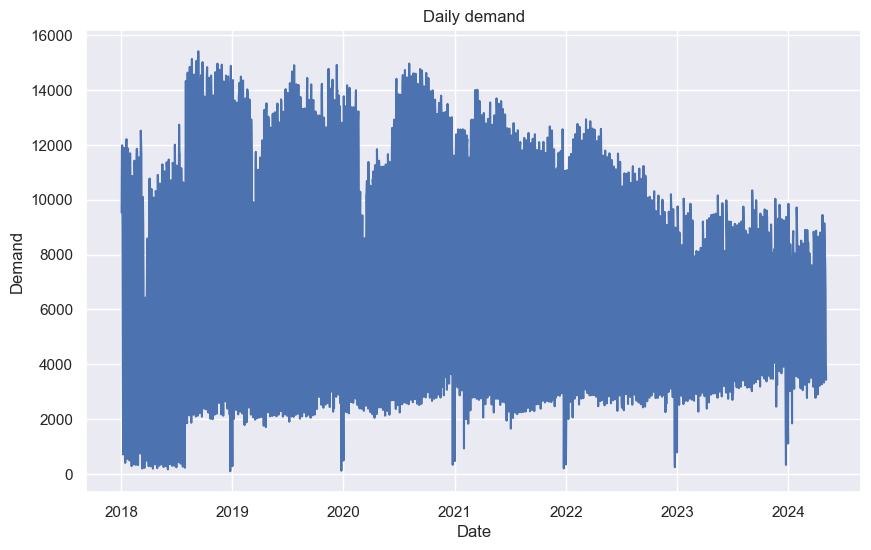

In [49]:
daily_demand = data.groupby(['timestamp'], as_index=False)['demand'].sum()
plt.figure(figsize=(10, 6))
plt.plot(daily_demand['timestamp'], daily_demand['demand'])
plt.title('Daily demand')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.grid(True)
plt.show()

Now, I have plotted individual items and city combinations to see if there are any trends following over time. 
We cannot say more by seeing these graphs, so we delve deep into them. 

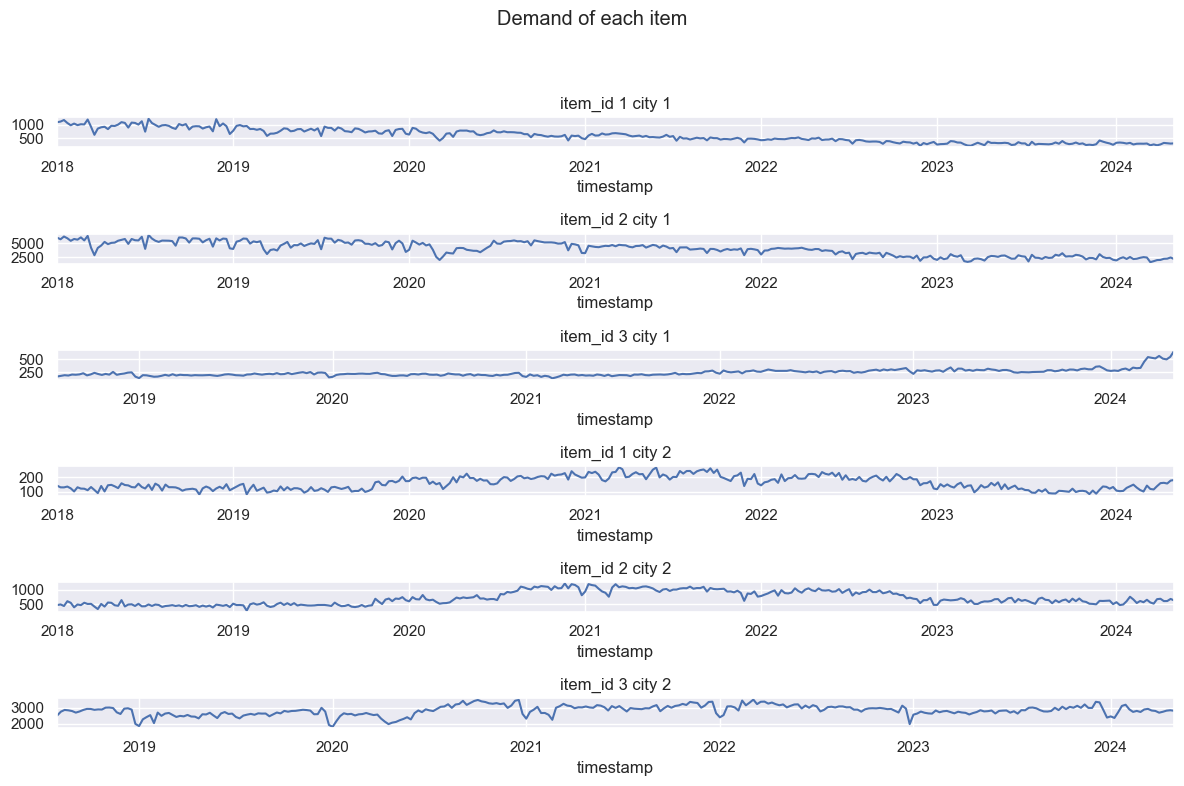

In [50]:
def update_ts_simple(city_1=1, city_2=2, i1_num=1, i2_num=2, i3_num=3):
    fig, ax = plt.subplots(6, figsize = (12, 8))
    data.query('city == @city_1 & item_id == @i1_num').set_index('timestamp')['demand'].resample('W').mean().plot(ax = ax[0])
    data.query('city == @city_1 & item_id == @i2_num').set_index('timestamp')['demand'].resample('W').mean().plot(ax = ax[1])
    data.query('city == @city_1 & item_id == @i3_num').set_index('timestamp')['demand'].resample('W').mean().plot(ax = ax[2])
    data.query('city == @city_2 & item_id == @i1_num').set_index('timestamp')['demand'].resample('W').mean().plot(ax = ax[3])
    data.query('city == @city_2 & item_id == @i2_num').set_index('timestamp')['demand'].resample('W').mean().plot(ax = ax[4])
    data.query('city == @city_2 & item_id == @i3_num').set_index('timestamp')['demand'].resample('W').mean().plot(ax = ax[5])

    ax[0].set_title('item_id {} city {}'.format(i1_num, city_1))
    ax[1].set_title('item_id {} city {}'.format(i2_num, city_1))
    ax[2].set_title('item_id {} city {}'.format(i3_num, city_1))
    ax[3].set_title('item_id {} city {}'.format(i1_num, city_2))
    ax[4].set_title('item_id {} city {}'.format(i2_num, city_2))
    ax[5].set_title('item_id {} city {}'.format(i3_num, city_2))
    fig.suptitle('Demand of each item')
    fig.tight_layout(rect=[0, 0, 1, 0.94])
    fig.canvas.draw()
    fig.show()

update_ts_simple(1,2,1,2,3)

Trend and seasonality:

Let's analyze sales trends and seasonalities. First, we add columns with date-related information: year, month, weekday, etc.


In [9]:
def create_date_features(df):
    df['month'] = df.timestamp.dt.month
    df['day'] = df.timestamp.dt.day

    df['day_of_month'] = df.timestamp.dt.day
    df['day_of_year'] = df.timestamp.dt.dayofyear
    df['week_of_year'] = df.timestamp.dt.isocalendar().week
    df['day_of_week'] = df.timestamp.dt.dayofweek
    df['year'] = df.timestamp.dt.year
    df["is_wknd"] = df.timestamp.dt.weekday // 4
    df['is_month_start'] = df.timestamp.dt.is_month_start.astype(int)
    df['is_month_end'] = df.timestamp.dt.is_month_end.astype(int)
    return df

data = create_date_features(data)
data.head(3)

,timestamp,region,city,item_id,demand,month,day,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2018-01-02,1,2,1,148,1,2,2,2,1,1,2018,0,0,0
1,2018-01-03,1,2,1,124,1,3,3,3,1,2,2018,0,0,0
2,2018-01-04,1,2,1,243,1,4,4,4,1,3,2018,0,0,0


We can see clear weekly seasonality patterns, which don't change with time. In the meanwhile, monthly and yearly seasonality is not very pronounced

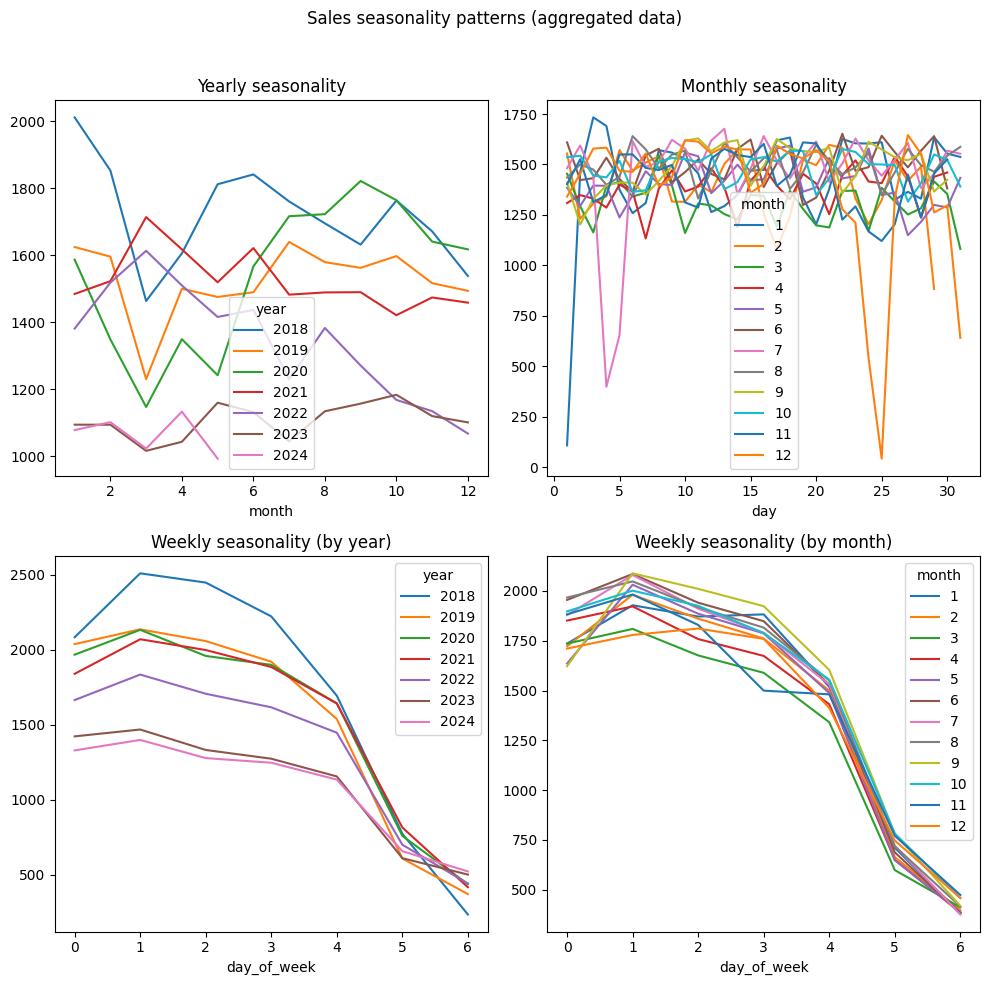

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
_ = pd.pivot_table(data, values='demand', columns='year', index='month').plot(title="Yearly seasonality", ax=ax[0,0])
_ = pd.pivot_table(data, values='demand', columns='month', index='day').plot(title="Monthly seasonality", ax=ax[0,1])
_ = pd.pivot_table(data, values='demand', columns='year', index='day_of_week').plot(title="Weekly seasonality (by year)", ax=ax[1,0])
_ = pd.pivot_table(data, values='demand', columns='month', index='day_of_week').plot(title="Weekly seasonality (by month)", ax=ax[1,1])
fig.suptitle('Sales seasonality patterns (aggregated data)')
fig.tight_layout(rect=[0, 0, 1, 0.96])

Growth by Month of Different Year

By seeing this graph, we can say that during summertime, overall demand is higher compared to other times of the year. Average demand is higher in August. 

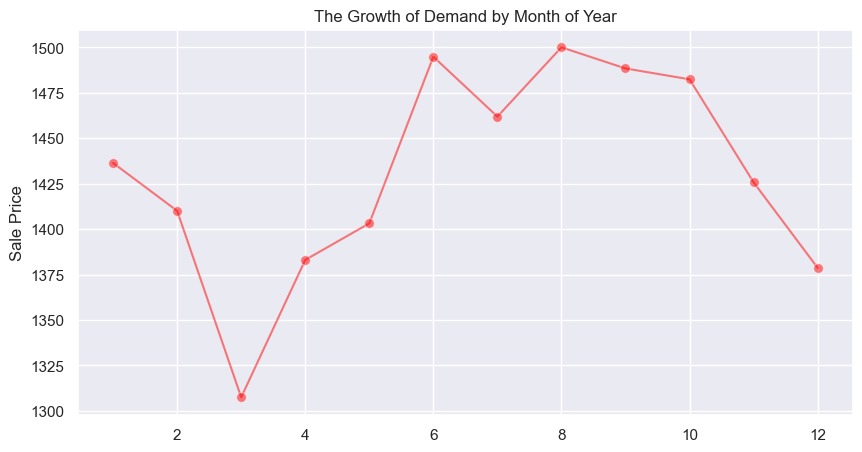

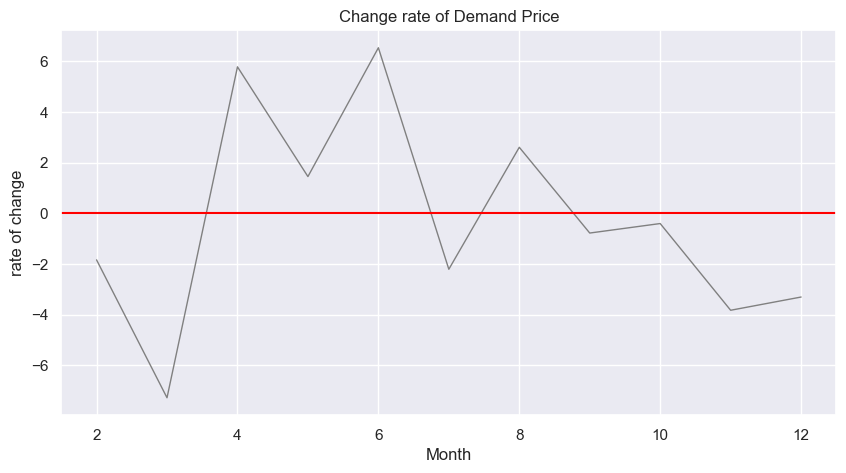

In [52]:
# Aggregate sales by Month
data_month = data.groupby('month')['demand'].mean().reset_index()

# Calculate the rate of change
data_month['rate'] = list(100 * data_month['demand'].diff() / data_month['demand'].shift(1))

# Create the first plot
plt.figure(figsize=(10, 5))
sl1 = sns.lineplot(data_month, x='month', y='demand', color='red', linewidth=1.5, marker='o', markersize=7, alpha=0.5)
plt.title("The Growth of Demand by Month of Year")
plt.xlabel(None)
plt.ylabel("Sale Price")

# Create the second plot
plt.figure(figsize=(10, 5))
sl2 = sns.lineplot(data_month, x='month', y='rate', color='gray', linewidth=1)
plt.title("Change rate of Demand Price")
plt.xlabel("Month")
plt.ylabel("rate of change")
plt.axhline(y=0, color='red')

plt.show()

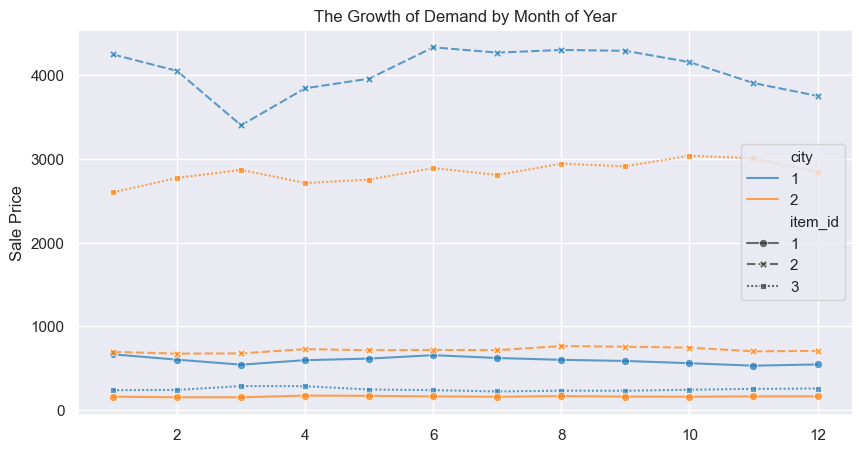

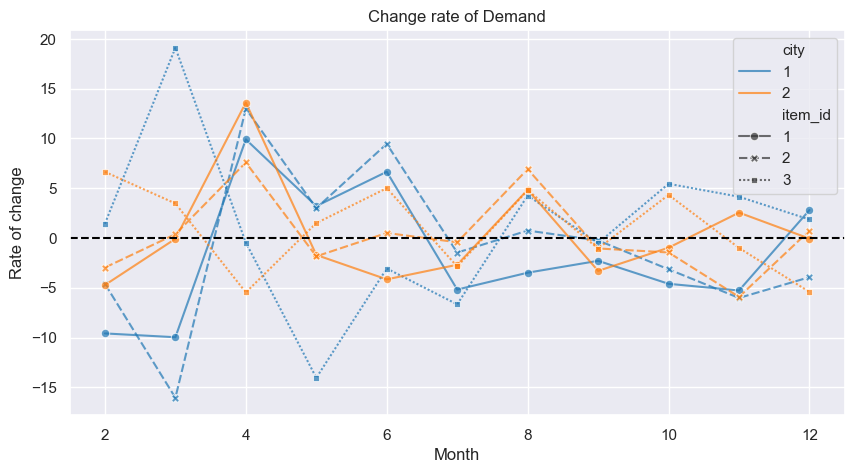

In [53]:
# Aggregate sales by Month, city, and item_id
data_month_city_item = data.groupby(['month', 'city', 'item_id'])['demand'].mean().reset_index()

# Calculate the rate of change
data_month_city_item['rate'] = list(100 * data_month_city_item.groupby(['city', 'item_id'])['demand'].diff() / data_month_city_item.groupby(['city', 'item_id'])['demand'].shift(1))

# Create the first plot
plt.figure(figsize=(10, 5))
sl1 = sns.lineplot(data=data_month_city_item, x='month', y='demand', hue='city', style='item_id', markers=True, palette='tab10', linewidth=1.5, alpha=0.7)
plt.title("The Growth of Demand by Month of Year")
plt.xlabel(None)
plt.ylabel("Sale Price")

# Create the second plot
plt.figure(figsize=(10, 5))
sl2 = sns.lineplot(data=data_month_city_item, x='month', y='rate', hue='city', style='item_id', markers=True, palette='tab10', linewidth=1.5, alpha=0.7)
plt.title("Change rate of Demand")
plt.xlabel("Month")
plt.ylabel("Rate of change")
plt.axhline(y=0, color='black', linestyle='--')

plt.show()


Growth by Different Year

By seeing this graph, we can say that Demand is decreasing over time. Average demand is higher in year 2018. 

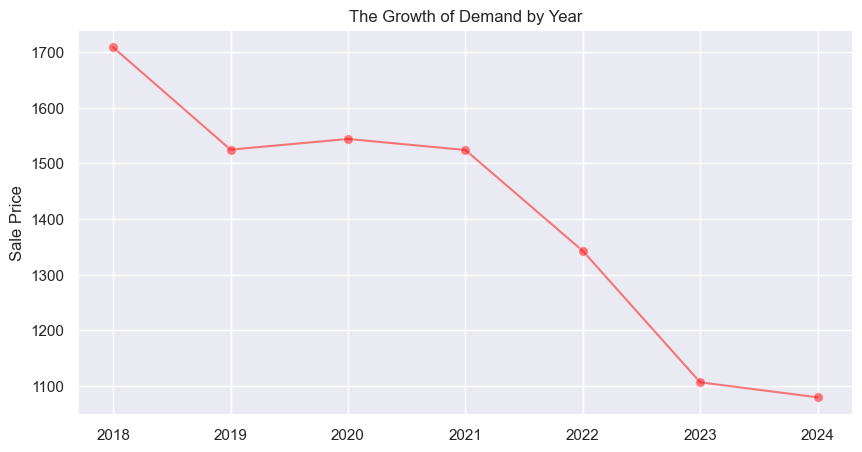

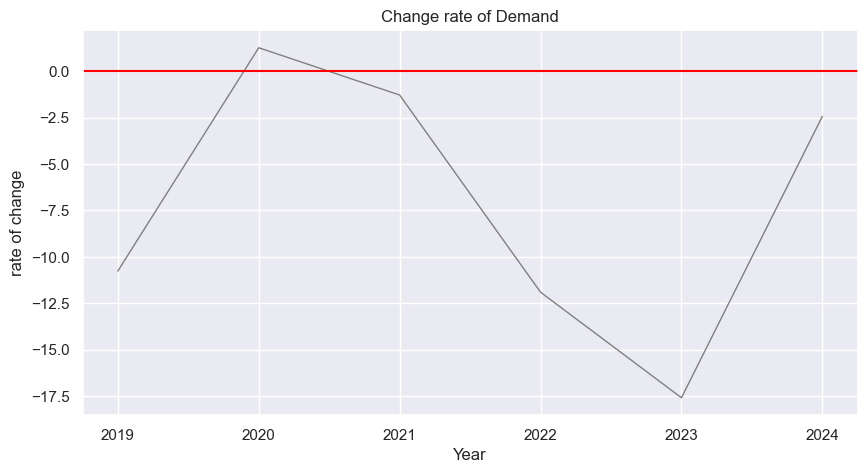

In [56]:
# Aggregate sales by Year
data_day = data.groupby(['year'])['demand'].mean().reset_index()

# Calculate the rate of change
data_day['rate'] = list(100 * data_day['demand'].diff() / data_day['demand'].shift(1))

# Create the first plot
plt.figure(figsize=(10, 5))
sl1 = sns.lineplot(data_day, x='year', y='demand', color='red', linewidth=1.5, marker='o', markersize=7, alpha=0.5)
plt.title("The Growth of Demand by Year")
plt.xlabel(None)
plt.ylabel("Sale Price")

# Create the second plot
plt.figure(figsize=(10, 5))
sl2 = sns.lineplot(data_day, x='year', y='rate', color='gray', linewidth=1)
plt.title("Change rate of Demand")
plt.xlabel("Year")
plt.ylabel("rate of change")
plt.axhline(y=0, color='red')

# Display the plots
plt.show()

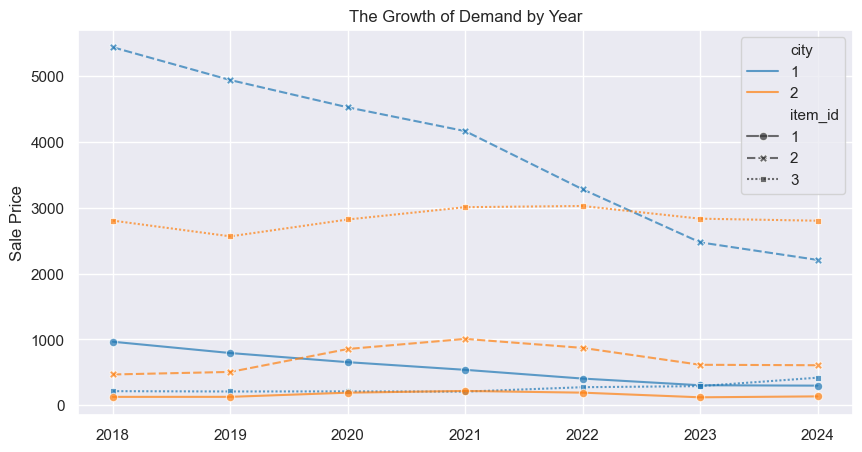

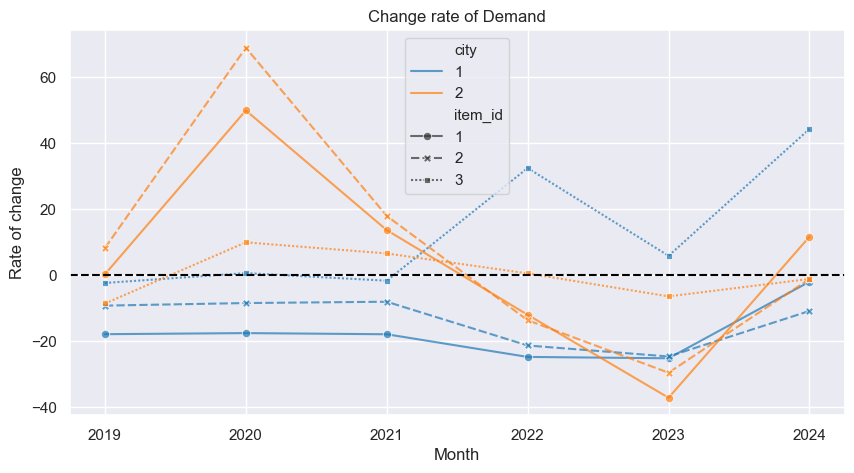

In [55]:
# Aggregate sales by Year, city, and item_id
data_month_city_item = data.groupby(['year', 'city', 'item_id'])['demand'].mean().reset_index()

# Calculate the rate of change
data_month_city_item['rate'] = list(100 * data_month_city_item.groupby(['city', 'item_id'])['demand'].diff() / data_month_city_item.groupby(['city', 'item_id'])['demand'].shift(1))

# Create the first plot
plt.figure(figsize=(10, 5))
sl1 = sns.lineplot(data=data_month_city_item, x='year', y='demand', hue='city', style='item_id', markers=True, palette='tab10', linewidth=1.5, alpha=0.7)
plt.title("The Growth of Demand by Year")
plt.xlabel(None)
plt.ylabel("Sale Price")

# Create the second plot
plt.figure(figsize=(10, 5))
sl2 = sns.lineplot(data=data_month_city_item, x='year', y='rate', hue='city', style='item_id', markers=True, palette='tab10', linewidth=1.5, alpha=0.7)
plt.title("Change rate of Demand")
plt.xlabel("Month")
plt.ylabel("Rate of change")
plt.axhline(y=0, color='black', linestyle='--')

plt.show()

Feature Engineering


Random Noise

To avoid overfitting, random noise can be added to the values. I will add Gaussian random noise, normally distributed with a standard deviation of 1 and a mean of 0.

In [15]:
def random_noise(dataframe):

    return np.random.normal(size=(len(dataframe),))

Lag/Shifted Features

Time Series theory states that the value in time: t highly depends on the value in time: t-1. That is why I will shift all the sales values by 1 and add noise.

I will use the current timestep and the last 29 to forecast 7 and 14 days.

In [16]:
# sort the values per store, item and date so that values would be shifted equally

data.sort_values(by=['city', 'item_id', 'timestamp'], axis=0, inplace=True)


In [17]:
# the feature name will be created dynamically with regards to the lag value for a given list of lags

def lag_features(dataframe, lags):
    dataframe = dataframe.copy()
    for lag in lags:
        dataframe['demand_lag_' + str(lag)] = dataframe.groupby(["city", "item_id"])['demand'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    
    return dataframe

In [18]:
lags = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,23,24,25,26,27,28,29,30,-7,-14]
data = lag_features(data, lags)
data

,timestamp,region,city,item_id,demand,month,day,day_of_month,day_of_year,week_of_year,...,demand_lag_23,demand_lag_24,demand_lag_25,demand_lag_26,demand_lag_27,demand_lag_28,demand_lag_29,demand_lag_30,demand_lag_-7,demand_lag_-14
8842,2018-01-02,2,1,1,1460,1,2,2,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1749.150113,1934.950851
8843,2018-01-03,2,1,1,1710,1,3,3,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1827.706648,1818.729391
8844,2018-01-04,2,1,1,1722,1,4,4,4,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1275.306457,1802.691497
8845,2018-01-05,2,1,1,1301,1,5,5,5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,975.490996,1271.979138
8846,2018-01-06,2,1,1,319,1,6,6,6,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,277.397690,278.903129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6732,2024-05-01,1,2,3,2791,5,1,1,122,18,...,3345.054638,2087.014112,2533.546936,2692.167671,2690.116669,2347.187987,3177.096278,3341.095133,NaN,NaN
6733,2024-05-02,1,2,3,2865,5,2,2,123,18,...,2919.605824,3346.105101,2085.819223,2533.317987,2691.915985,2689.731033,2348.082852,3175.306681,NaN,NaN
6734,2024-05-03,1,2,3,3084,5,3,3,124,18,...,2220.664492,2919.523894,3347.437688,2087.278862,2534.266415,2692.635383,2691.319166,2349.077809,NaN,NaN
6735,2024-05-04,1,2,3,2656,5,4,4,125,18,...,2836.406241,2220.269180,2918.665198,3348.211068,2087.861683,2533.541950,2692.373701,2691.566619,NaN,NaN


In [19]:
def roll_mean_features(dataframe, windows):
    dataframe = dataframe.copy()
    for window in windows:
        dataframe['demand_roll_mean_' + str(window)] = dataframe.groupby(["city", "item_id"])['demand']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(dataframe)
    return dataframe

In [20]:
data = roll_mean_features(data, [10, 20, 30])
data.tail()

,timestamp,region,city,item_id,demand,month,day,day_of_month,day_of_year,week_of_year,...,demand_lag_26,demand_lag_27,demand_lag_28,demand_lag_29,demand_lag_30,demand_lag_-7,demand_lag_-14,demand_roll_mean_10,demand_roll_mean_20,demand_roll_mean_30
6732,2024-05-01,1,2,3,2791,5,1,1,122,18,...,2692.167671,2690.116669,2347.187987,3177.096278,3341.095133,NaN,NaN,2794.981143,2834.323313,2787.518986
6733,2024-05-02,1,2,3,2865,5,2,2,123,18,...,2533.317987,2691.915985,2689.731033,2348.082852,3175.306681,NaN,NaN,2749.084359,2841.434049,2791.345541
6734,2024-05-03,1,2,3,3084,5,3,3,124,18,...,2087.278862,2534.266415,2692.635383,2691.319166,2349.077809,NaN,NaN,2731.568534,2845.169792,2797.324377
6735,2024-05-04,1,2,3,2656,5,4,4,125,18,...,3348.211068,2087.861683,2533.541950,2692.373701,2691.566619,NaN,NaN,2761.307523,2838.286371,2803.168190
6736,2024-05-05,1,2,3,2502,5,5,5,126,18,...,2918.078844,3347.422515,2087.088745,2535.035069,2692.378372,NaN,NaN,2794.842248,2823.306087,2809.638989


Exponentially Weighted Mean Features

The value in time t highly depends on the value in time t-1, so in order to have a better prediction, while computing the average value, the values should not be equally weighted.



In [21]:
def ewm_features(dataframe, alphas, lags):
    dataframe = dataframe.copy()
    for alpha in alphas:
        for lag in lags:
            dataframe['demand_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["city", "item_id"])['demand']. \
                    transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

In [22]:
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags_1 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,23,24,25,26,27,28,29,30]
data = ewm_features(data, alphas, lags_1)
data.tail()

,timestamp,region,city,item_id,demand,month,day,day_of_month,day_of_year,week_of_year,...,demand_ewm_alpha_05_lag_20,demand_ewm_alpha_05_lag_21,demand_ewm_alpha_05_lag_23,demand_ewm_alpha_05_lag_24,demand_ewm_alpha_05_lag_25,demand_ewm_alpha_05_lag_26,demand_ewm_alpha_05_lag_27,demand_ewm_alpha_05_lag_28,demand_ewm_alpha_05_lag_29,demand_ewm_alpha_05_lag_30
6732,2024-05-01,1,2,3,2791,5,1,1,122,18,...,2695.210275,2552.420550,2848.682198,2350.364396,2613.728792,2693.457584,2693.915169,2697.830338,3047.660675,2919.321350
6733,2024-05-02,1,2,3,2865,5,2,2,123,18,...,2822.605137,2695.210275,2883.841099,2848.682198,2350.364396,2613.728792,2693.457584,2693.915169,2697.830338,3047.660675
6734,2024-05-03,1,2,3,3084,5,3,3,124,18,...,2692.802569,2822.605137,2552.420550,2883.841099,2848.682198,2350.364396,2613.728792,2693.457584,2693.915169,2697.830338
6735,2024-05-04,1,2,3,2656,5,4,4,125,18,...,2560.901284,2692.802569,2695.210275,2552.420550,2883.841099,2848.682198,2350.364396,2613.728792,2693.457584,2693.915169
6736,2024-05-05,1,2,3,2502,5,5,5,126,18,...,3025.950642,2560.901284,2822.605137,2695.210275,2552.420550,2883.841099,2848.682198,2350.364396,2613.728792,2693.457584


Custom Cost Function

I will define a custom cost function which is based on SMAPE which reverses the log values and calculates the SMAPE.



In [23]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds-target)
    denom = np.abs(preds)+np.abs(target)
    smape_val = (200*np.sum(num/denom))/n
    return smape_val

def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

Train-Validation Split

In [24]:
train = data.loc[(data["timestamp"] < "2023-01-01"), :]
train["timestamp"].min(), train["timestamp"].max()

(Timestamp('2018-01-02 00:00:00'), Timestamp('2022-12-31 00:00:00'))

In [25]:
val = data.loc[(data["timestamp"] >= "2023-01-01"), :]


In [29]:
cols = [col for col in train.columns if col not in ['timestamp', "demand", "year","demand_lag_-7","demand_lag_-14"]]


In [30]:
Y_train_7 = train['demand_lag_-7']
Y_train_14 = train['demand_lag_-14']
X_train = train[cols]

Y_val_7 = val['demand_lag_-7']
Y_val_14 = val['demand_lag_-14']

X_val = val[cols]

In [31]:
Y_train_7.shape, X_train.shape, Y_val_7.shape, X_val.shape


((10519,), (10519, 189), (2945,), (2945, 189))

LightGBM - Default Parameters

first_model is train to forecast demand in 7 days advance 
first_mode_14 is train to forecast demand in 14 days advance

In [32]:
first_model = lgb.LGBMRegressor(random_state=384).fit(X_train, Y_train_7, 
                                                      eval_metric= lambda y_true, y_pred: [lgbm_smape(y_true, y_pred)])

print("TRAIN SMAPE:", smape(Y_train_7, first_model.predict(X_train)))
print("VALID SMAPE:", smape(Y_val_7, first_model.predict(X_val)))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45543
[LightGBM] [Info] Number of data points in the train set: 10519, number of used features: 189
[LightGBM] [Info] Start training from score 1518.073065
TRAIN SMAPE: 20.597139436410778
VALID SMAPE: 24.184304302166385


In [42]:
first_model_14 = lgb.LGBMRegressor(random_state=384).fit(X_train, Y_train_14, 
                                                      eval_metric= lambda y_true, y_pred: [lgbm_smape(y_true, y_pred)])

print("TRAIN SMAPE:", smape(Y_train_14, first_model.predict(X_train)))
print("VALID SMAPE:", smape(Y_val_14, first_model.predict(X_val)))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45543
[LightGBM] [Info] Number of data points in the train set: 10519, number of used features: 189
[LightGBM] [Info] Start training from score 1515.403599
TRAIN SMAPE: 23.141723279932915
VALID SMAPE: 24.268837927226926


Feature Importance

In [33]:

def plot_lgb_importances(model, plot=False, num=10):
    from matplotlib import pyplot as plt
    import seaborn as sns
    
    # LGBM API
    #gain = model.feature_importance('gain')
    #feat_imp = pd.DataFrame({'feature': model.feature_name(),
    #                         'split': model.feature_importance('split'),
    #                         'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    
    # SKLEARN API
    gain = model.booster_.feature_importance(importance_type='gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name_,
                             'split': model.booster_.feature_importance(importance_type='split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
        return feat_imp

feature_imp_df = plot_lgb_importances(first_model, num=50)


                         feature  split       gain
18                  demand_lag_7     87  44.180314
50    demand_ewm_alpha_095_lag_7     63  31.686438
165    demand_ewm_alpha_05_lag_6     35   4.408919
64   demand_ewm_alpha_095_lag_21     17   3.932055
32                 demand_lag_21     31   1.788004
79     demand_ewm_alpha_09_lag_7     32   1.499365
57   demand_ewm_alpha_095_lag_14     28   1.493279
38                 demand_lag_28     38   0.828532
99    demand_ewm_alpha_09_lag_28     25   0.802565
25                 demand_lag_14     56   0.797446
6                    day_of_year    218   0.736870
179   demand_ewm_alpha_05_lag_20     23   0.584264
12                  demand_lag_1     93   0.516805
70   demand_ewm_alpha_095_lag_28     22   0.478406
185   demand_ewm_alpha_05_lag_27     21   0.370095
160    demand_ewm_alpha_05_lag_1     41   0.314247
4                            day     91   0.259747
98    demand_ewm_alpha_09_lag_27     18   0.205059
8                    day_of_wee

In [34]:
feature_imp_df.shape, feature_imp_df[feature_imp_df.gain > 0].shape, feature_imp_df[feature_imp_df.gain > 0.57].shape


((189, 3), (184, 3), (12, 3))

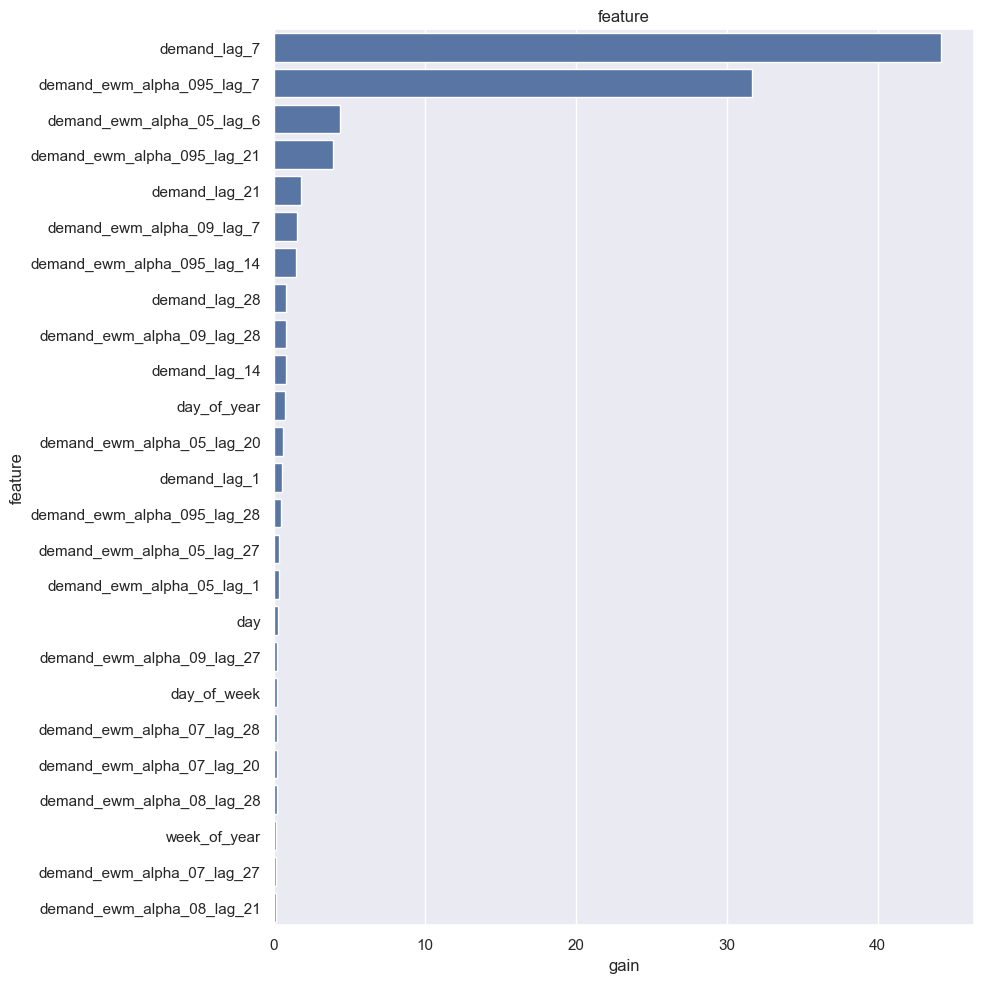

In [35]:
plot_lgb_importances(first_model, plot=True, num=30)


Error Analysis

In [38]:
error = pd.DataFrame({
    "timestamp":val.timestamp,
    "city":X_val.city,
    "item_id":X_val.item_id,
    "actual":Y_val_7,
    "pred":first_model.predict(X_val)
}).reset_index(drop = True)

error["error"] = np.abs(error.actual-error.pred)

error.sort_values("error", ascending=False).head(20)

,timestamp,city,item_id,actual,pred,error
668,2023-06-28,1,2,178.811018,3750.688965,3571.877947
631,2023-05-22,1,2,428.492215,3767.849340,3339.357126
729,2023-08-28,1,2,5.025743,3246.778606,3241.752863
667,2023-06-27,1,2,427.517764,3522.240735,3094.722971
533,2023-02-13,1,2,433.127524,3511.912598,3078.785074
697,2023-07-27,1,2,445.902815,3434.624931,2988.722116
2813,2023-12-26,2,3,4215.036334,1374.115540,2840.920794
809,2023-11-16,1,2,239.887319,2937.513403,2697.626084
2806,2023-12-19,2,3,4315.073078,1938.919100,2376.153978
543,2023-02-23,1,2,1990.993104,4133.712881,2142.719777


City 1 Validation Set: Actual & Pred

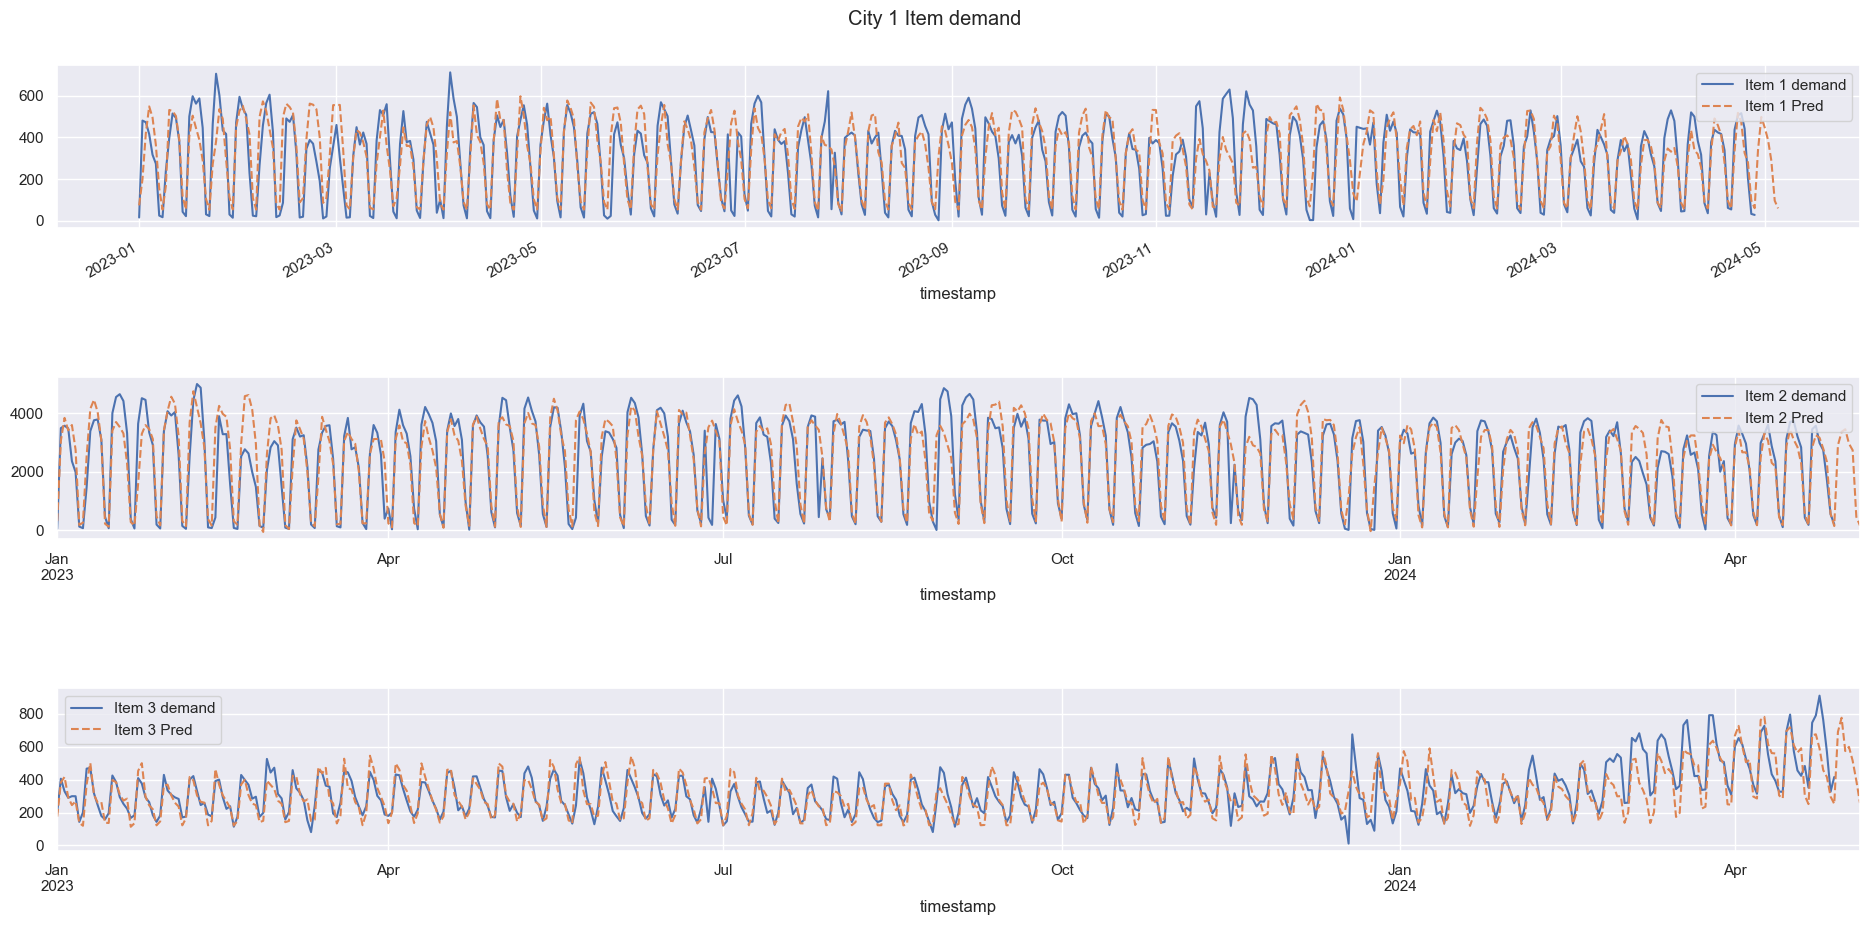

In [58]:
sub = error[error.city == 1].set_index("timestamp")
fig, axes = plt.subplots(3, figsize=(20, 10))
for i in range(1,4):
    if i < 4:
        sub[sub.item_id == i].actual.plot(ax=axes[i-1], legend=True, label = "Item "+str(i)+" demand")
        sub[sub.item_id == i].pred.plot(ax=axes[i-1], legend=True, label="Item " + str(i) + " Pred", linestyle = "dashed")
    
plt.tight_layout(pad=4.5)
plt.suptitle("City 1 Item demand");
plt.show()

Forecasting demand in 7 days advance for city 1 and item 1

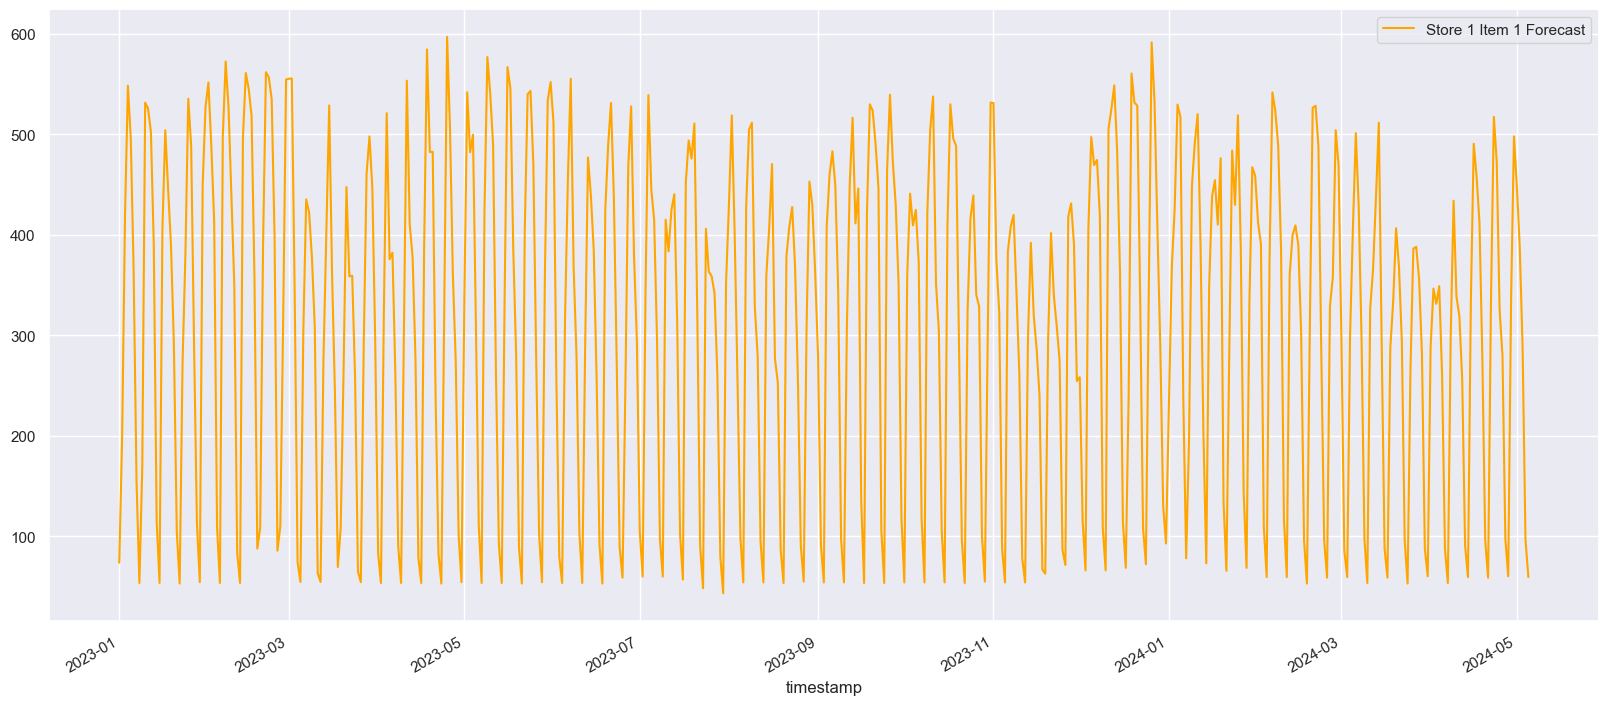

In [40]:
train_final = data.loc[(data["timestamp"] < "2023-01-01"), :]
test_final = data.loc[(data["timestamp"] >= "2023-01-01"), :]

forecast = pd.DataFrame({
    "timestamp":test_final.timestamp,
    "city":test_final.city,
    "item_id":test_final.item_id,
    "demand":first_model.predict(X_val)
})

forecast[(forecast.city == 1) & (forecast.item_id == 1)].set_index("timestamp").demand.plot(color = "orange", figsize = (20,9),legend=True, label = "Store 1 Item 1 Forecast");

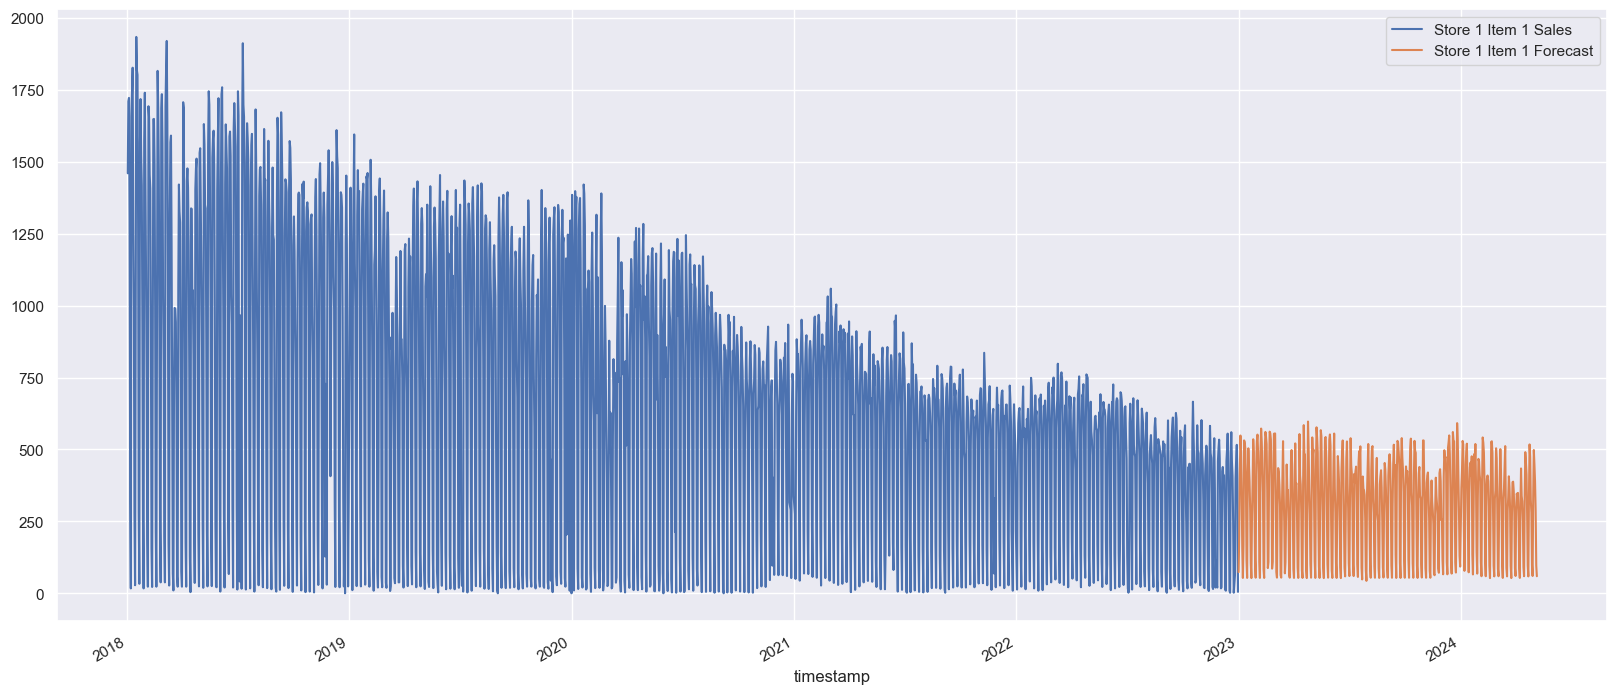

In [41]:
train_final[(train_final.city == 1) & (train_final.item_id == 1)].set_index("timestamp").demand.plot(figsize = (20,9),legend=True, label = "Store 1 Item 1 Sales")
forecast[(forecast.city == 1) & (forecast.item_id == 1)].set_index("timestamp").demand.plot(legend=True, label = "Store 1 Item 1 Forecast");


Forecasting demand in 14 days advance for city 1 and item 1

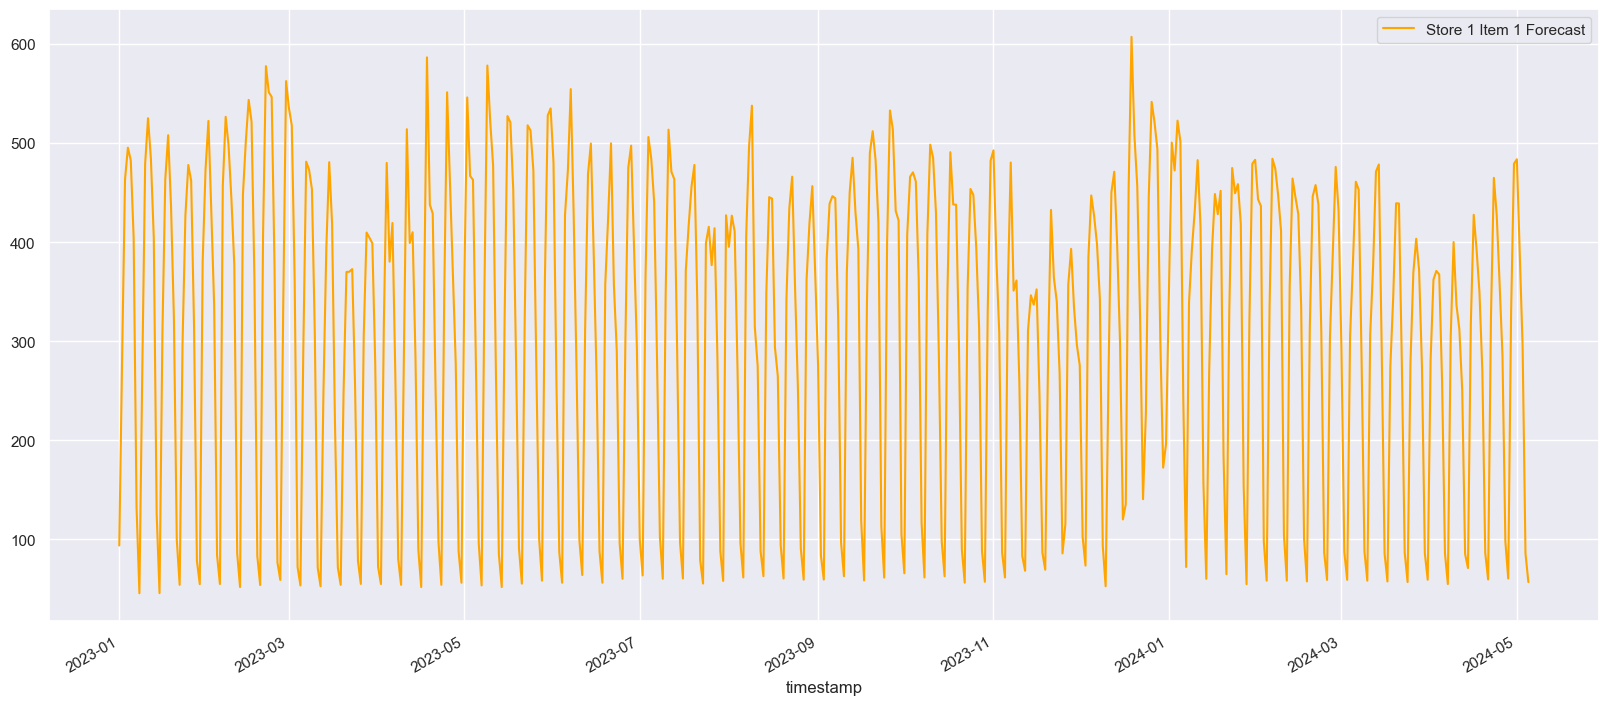

In [43]:
train_final = data.loc[(data["timestamp"] < "2023-01-01"), :]
test_final = data.loc[(data["timestamp"] >= "2023-01-01"), :]

forecast = pd.DataFrame({
    "timestamp":test_final.timestamp,
    "city":test_final.city,
    "item_id":test_final.item_id,
    "demand":first_model_14.predict(X_val)
})

forecast[(forecast.city == 1) & (forecast.item_id == 1)].set_index("timestamp").demand.plot(color = "orange", figsize = (20,9),legend=True, label = "Store 1 Item 1 Forecast");

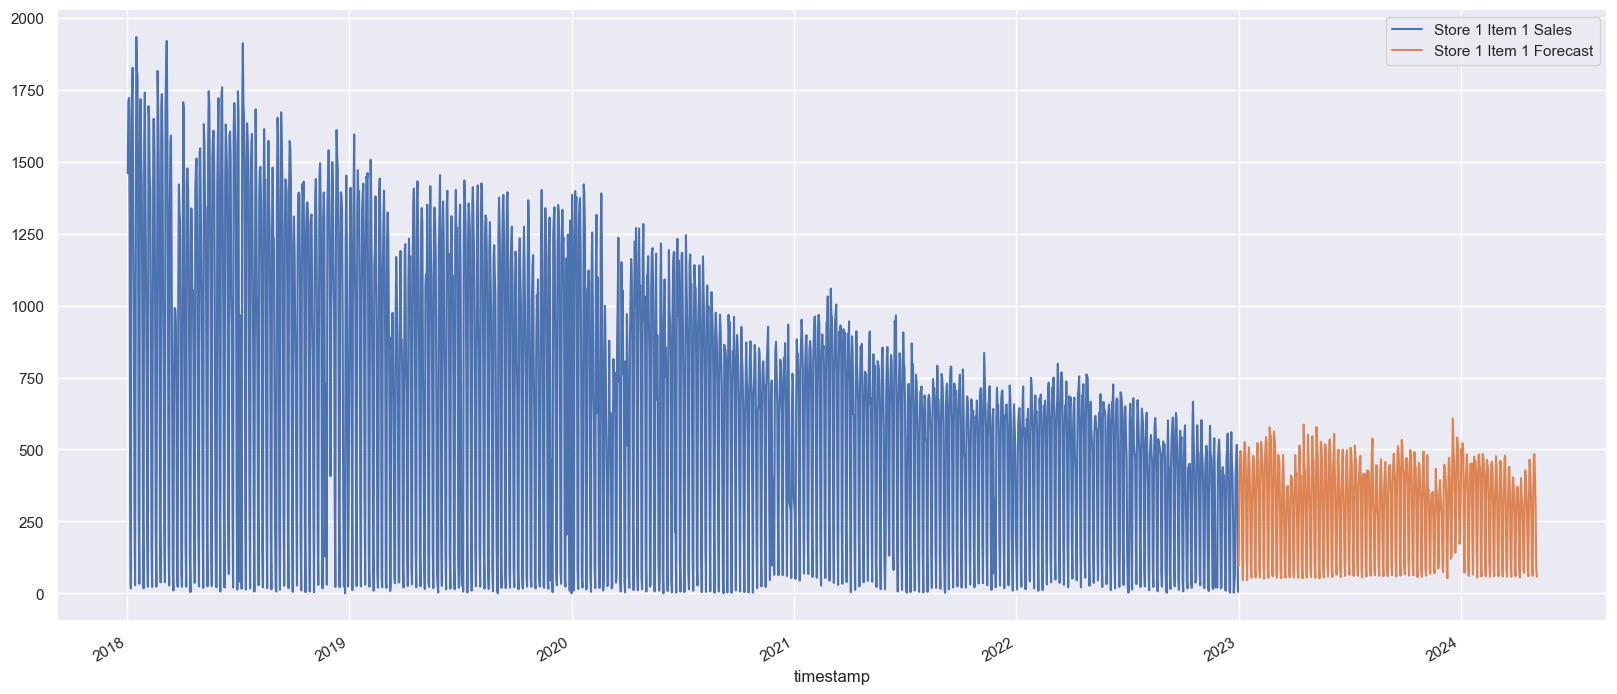

In [44]:
train_final[(train_final.city == 1) & (train_final.item_id == 1)].set_index("timestamp").demand.plot(figsize = (20,9),legend=True, label = "Store 1 Item 1 Sales")
forecast[(forecast.city == 1) & (forecast.item_id == 1)].set_index("timestamp").demand.plot(legend=True, label = "Store 1 Item 1 Forecast");
